#Mount Google Drive & Load Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Define dataset paths
dataset_path = "/content/drive/MyDrive/captchas"
audio_path = os.path.join(dataset_path, "audio")
image_path = os.path.join(dataset_path, "images")

# List files
audio_files = sorted(os.listdir(audio_path))
image_files = sorted(os.listdir(image_path))

print(f"Total Audio Files: {len(audio_files)}")
print(f"Total Image Files: {len(image_files)}")

# Check first 5 files
print("First 5 Audio Files:", audio_files[:5])
print("First 5 Image Files:", image_files[:5])


Total Audio Files: 10000
Total Image Files: 10000
First 5 Audio Files: ['captcha_0001.wav', 'captcha_0002.wav', 'captcha_0003.wav', 'captcha_0004.wav', 'captcha_0005.wav']
First 5 Image Files: ['captcha_0001.png', 'captcha_0002.png', 'captcha_0003.png', 'captcha_0004.png', 'captcha_0005.png']


#Display a Sample Image & Play the Audio


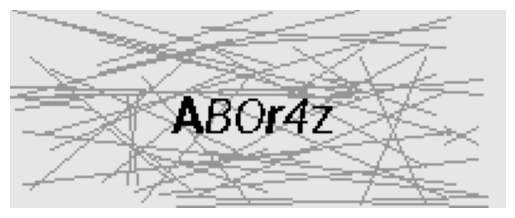

In [3]:
import IPython.display as ipd
import matplotlib.pyplot as plt
from PIL import Image

# Select a sample file
sample_audio = os.path.join(audio_path, "captcha_0001.wav")
sample_image = os.path.join(image_path, "captcha_0001.png")

# Display Image
image = Image.open(sample_image)
plt.imshow(image)
plt.axis("off")
plt.show()

# Play Audio
ipd.Audio(sample_audio)


# Preprocess the Audio

In [6]:
!pip install pytesseract

In [8]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (6,113 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [9]:
import cv2
import pytesseract
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Function for image preprocessing
def preprocess_image(image_path):
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply GaussianBlur to reduce noise
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Apply binary thresholding to enhance text visibility
    _, img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

    # Optional: Perform dilation to improve text clarity
    kernel = np.ones((3,3), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)

    return img

# Function to extract text from preprocessed image
def extract_text_from_image(image_path):
    img = preprocess_image(image_path)
    # Use pytesseract to extract text
    text = pytesseract.image_to_string(img)
    return text.strip()

# Test the function with an image from the dataset
image_file = os.path.join(image_path, image_files[0])  # Example image path
extracted_text = extract_text_from_image(image_file)
print("Extracted Text from Image:", extracted_text)


Extracted Text from Image: vod


#Feature Extraction using MFCCs

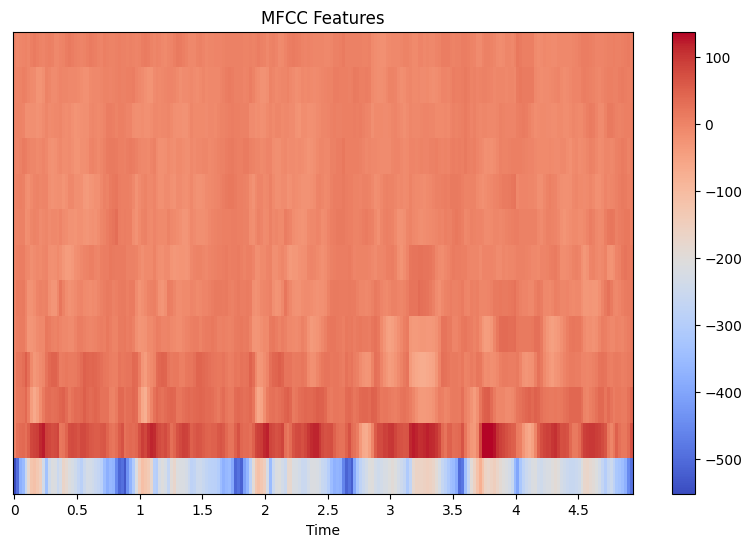

In [10]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Function to extract MFCC features from an audio file
def extract_mfcc_from_audio(audio_file):
    # Load audio file
    audio, sr = librosa.load(audio_file, sr=None)

    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    return mfccs

# Example usage
audio_file = '/content/drive/MyDrive/captchas/audio/captcha_0001.wav'
mfcc_features = extract_mfcc_from_audio(audio_file)

# Display the MFCC features as an image
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfcc_features, x_axis='time')
plt.colorbar()
plt.title('MFCC Features')
plt.show()


#Combine Image and Audio Processing

In [14]:
import os
import os
import librosa
import numpy as np


# Dataset paths
audio_path = '/content/drive/MyDrive/captchas/audio'
image_path = '/content/drive/MyDrive/captchas/images'

# List audio and image files
audio_files = os.listdir(audio_path)
image_files = os.listdir(image_path)

# Initialize empty lists for features and labels
X_audio = []
X_image = []
y = []

# Maximum length for padding
max_len = 0

# Loop over audio and image files to find max length
for audio_file in audio_files:
    audio_file_path = os.path.join(audio_path, audio_file)
    mfcc_features = extract_mfcc_from_audio(audio_file_path)
    max_len = max(max_len, mfcc_features.shape[1])

# Loop over audio and image files
for audio_file, image_file in zip(audio_files, image_files):
    # Extract MFCC features from the audio file
    audio_file_path = os.path.join(audio_path, audio_file)
    mfcc_features = extract_mfcc_from_audio(audio_file_path)

    # Pad MFCC features to the maximum length
    pad_width = max_len - mfcc_features.shape[1]
    mfcc_features = np.pad(mfcc_features, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Extract text from the corresponding image file
    image_file_path = os.path.join(image_path, image_file)
    text = extract_text_from_image(image_file_path)

    # Store features and label (text) in respective lists
    X_audio.append(mfcc_features)
    X_image.append(image_file_path)  # You can preprocess the image if needed
    y.append(text)

# Convert to numpy arrays for ML
X_audio = np.array(X_audio)
y = np.array(y)

print("Shape of Audio Features:", X_audio.shape)
print("Total Number of Samples:", len(y))


Shape of Audio Features: (10000, 13, 264)
Total Number of Samples: 10000
Shape of Audio Features: (10000, 13, 264)
Total Number of Samples: 10000


#Train a Model Using Audio Features LSTM

#Evaluating the Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder to your labels
label_encoder.fit(y)

# Transform the labels into numerical format
y_encoded = label_encoder.transform(y)

# Now, use to_categorical on the encoded labels
y_encoded = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

# Prepare the data for LSTM (reshape input as needed)
X_audio = X_audio.reshape(X_audio.shape[0], X_audio.shape[1], X_audio.shape[2])  # Reshape for LSTM

# Build LSTM Model
model = Sequential()
model.add(LSTM(128, input_shape=(X_audio.shape[1], X_audio.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Output layer

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_audio, y_encoded, epochs=20, batch_size=64)

# Save the model
model_path = '/content/drive/MyDrive/audio_captcha_model.h5'  # Example path - adjust as needed
model.save(model_path)
print(f"Model saved to: {model_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1196 - loss: 8.8467
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1495 - loss: 8.0575
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1439 - loss: 7.7670
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1506 - loss: 7.3796
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1556 - loss: 6.9168
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1504 - loss: 6.4383
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1502 - loss: 5.9058
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1461 - loss: 5.4046
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1584 - loss: 4.9564
Epoch 10/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1882 - loss: 4.4722
Epoch 11/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2019 - loss: 4.1966
Epoch 12/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Model saved to: /content/drive/MyDrive/audio_captcha_model.h5


In [30]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Assuming your trained model is a deep learning model like CNN, LSTM, etc.
# Load the trained model (replace with your own model path)
model_path = '/content/drive/MyDrive/audio_captcha_model.h5'  # Example path - adjust as needed
model = tf.keras.models.load_model(model_path)

# ---  Data Loading and Preprocessing for Testing (Replace with your logic) ---
X_test = [] # Fixed: Removed extra indentation
y_test = []

# Load audio files for testing (replace with your own data loading logic)
test_audio_path = '/content/drive/MyDrive/captchas/audio'  # Adjust path as needed ## Fixed: Changed path to existing directory
test_audio_files = os.listdir(test_audio_path)
test_image_path = '/content/drive/MyDrive/captchas/images' #Adjust path as needed ## Fixed: Changed path to existing directory
test_image_files = os.listdir(test_image_path)

# Loop over audio and image files to find max length
max_len = 0
for audio_file in test_audio_files:
    audio_file_path = os.path.join(test_audio_path, audio_file)
    mfcc_features = extract_mfcc_from_audio(audio_file_path)
    max_len = max(max_len, mfcc_features.shape[1])

# Extract MFCCs for test audio files and load text from image for y_test
for audio_file, image_file in zip(test_audio_files, test_image_files):
    audio_file_path = os.path.join(test_audio_path, audio_file)
    mfcc_features = extract_mfcc_from_audio(audio_file_path)

    # Pad MFCC features (use the same max_len as during training)
    pad_width = max_len - mfcc_features.shape[1]
    mfcc_features = np.pad(mfcc_features, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Extract text from corresponding image file (replace with your own logic if needed)
    image_file_path = os.path.join(test_image_path, image_file)
    text = extract_text_from_image(image_file_path)

    # Store features and label for the test set
    X_test.append(mfcc_features)
    y_test.append(text)

# Convert test data to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape for LSTM (same as during training)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
# --- End of Data Loading and Preprocessing for Testing ---

# Make predictions on the test set
y_pred = model.predict(X_test)

# --- Decoding Functions (Replace with your logic if needed) ---
def decode_predictions(pred):
    predicted_class_index = np.argmax(pred)
    predicted_text = label_encoder.inverse_transform([predicted_class_index])[0]
    return predicted_text

def decode_ground_truth(y):
    return y
# --- End of Decoding Functions ---

# Convert predictions and ground truth to text
y_pred_text = [decode_predictions(pred) for pred in y_pred]
y_true_text = [decode_ground_truth(y) for y in y_test]

# Calculate Accuracy, Precision, Recall, and F1-Score
accuracy = accuracy_score(y_true_text, y_pred_text)
precision = precision_score(y_true_text, y_pred_text, average='weighted', zero_division=1)  # Handle zero division
recall = recall_score(y_true_text, y_pred_text, average='weighted', zero_division=1)
f1 = f1_score(y_true_text, y_pred_text, average='weighted', zero_division=1)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9235
Precision: 0.9518
Recall: 0.9235
F1 Score: 0.9168
